**Dataset**: https://www.nature.com/articles/s41597-024-03237-9

**Encoder and Decoder Reference**: https://www.youtube.com/watch?v=U0s0f995w14

**user ID** is the unique identifier of the mobile phone user (type: integer)

**day** is the masked date of the observation. It may take a value between 0 and 74 for both Dataset 1 and Dataset 2 (type: integer).

The location pings are discretized into 500 meters × 500 meters grid cells and the timestamps are rounded up into 30-minute bins. The actual date of the observations is not available either (i.e., timeslot t of day d) to protect privacy. In the second Dataset, the 75 day period is composed of 60 days of business-as-usual and 15 days during an emergency with unusual behavior.

**timeslot** is the timestamp of the observation discretized into 30 minute intervals. 
It may take a value between 0 and 47, where 0 indicates between 0AM and 0:30AM, 
and 13 would indicate the timeslot between 6:30AM and 7:00AM.

**x,y** are the coordinates of the observed location mapped onto the 500 meter discretized grid cell. It may take a value between (1, 1) and (200, 200). Details are shown in Fig. 2.

# Import Libraries

In [99]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Input Data Processing + Tokenization

In [1]:
# yjmob1 = 'yjmob100k-dataset1.csv.gz'
# yjmob2 = 'yjmob100k-dataset2.csv.gz'
# yjmob_df = pd.concat([pd.read_csv(yjmob1, compression='gzip'),
#                       pd.read_csv(yjmob2, compression='gzip')]).sort_values(by=['uid','d','t'],
#                                                                             ignore_index=True)

In [2]:
yjmob1 = 'yjmob100k-dataset1.csv.gz' # dataset under normal scenes
yjmob_df = pd.read_csv(yjmob1, compression='gzip').sort_values(by=['uid', 'd', 't'], ignore_index=True)

### Train-Val-Test Split

In [3]:
# Retrieve all ids

uids = yjmob_df['uid'].unique()

In [4]:
# 70 : 15 : 15 split

# test-train split
train_val_uids, test_uids = train_test_split(uids, test_size=0.15, random_state=42)

# validation-test split
train_uids, val_uids = train_test_split(train_val_uids, test_size=0.176, random_state=42) # 0.176≈15/85

### Load Test Data

In [5]:
df = yjmob_df[yjmob_df['uid'].isin(test_uids)]

In [6]:
df.head(5)

,uid,d,t,x,y
35039,23,0,24,47,183
35040,23,0,25,55,188
35041,23,0,26,55,188
35042,23,0,29,50,187
35043,23,0,30,47,182


### Tokenize Time Data

In [7]:
# df[['t']].min(), df[['t']].max() # [0, 47]
# df[['d']].min(), df[['d']].max() # [0, 74]

In [8]:
df['combined_t'] = df['d']*47+df['t']

## Ignore the SettingWithCopyWarning

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_65242/4212691307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_t'] = df['d']*47+df['t']


In [9]:
df.head(5)

,uid,d,t,x,y,combined_t
35039,23,0,24,47,183,24
35040,23,0,25,55,188,25
35041,23,0,26,55,188,26
35042,23,0,29,50,187,29
35043,23,0,30,47,182,30


### Tokenize Spatial Data

In [10]:
# linearization of the 2-dimensional grid, i.e., the original x,y coordinate system
def spatial_token(x, y):
    # x,y are the coordinate location
    # x determines the column order while
    # y determines the row order
    # (x-1) calculates the starting grid-column position
    # (y-1)*200 calculates the start index of the grid-row
    return (x-1)+(y-1)*200

In [11]:
df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)

## Ignore the SettingWithCopyWarning

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_65242/424670490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)


In [12]:
df.head(5)

,uid,d,t,x,y,combined_t,combined_xy
35039,23,0,24,47,183,24,36446
35040,23,0,25,55,188,25,37454
35041,23,0,26,55,188,26,37454
35042,23,0,29,50,187,29,37249
35043,23,0,30,47,182,30,36246


In [13]:
# original data

# df['combined_t'].min(), df['combined_t'].max() # (0, 3525)
# df['combined_xy'].min(), df['combined_xy'].max() # (0, 39999)

df = df.sort_values(by=['uid', 'combined_t'])

In [14]:
df.head(5)

,uid,d,t,x,y,combined_t,combined_xy
35039,23,0,24,47,183,24,36446
35040,23,0,25,55,188,25,37454
35041,23,0,26,55,188,26,37454
35042,23,0,29,50,187,29,37249
35043,23,0,30,47,182,30,36246


## Batching

In [138]:
def generate_sequences(data, data_t, window_size):
    inputs = []
    labels = []
    positions = []
    label_positions = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size]
        label = data[i + window_size]
        time_sequence = data_t[i:i + window_size]
        label_time = data_t[i + window_size]

        inputs.append(sequence)
        labels.append(label)
        positions.append(time_sequence)
        label_positions.append(label_time)
        
    return inputs, labels, positions, label_positions

In [139]:
WINDOW_SIZE = 500
BATCH_SIZE = 50

In [140]:
# Group data by uid

grouped_data = df[['uid', 'combined_t', 'combined_xy']].groupby('uid')
grouped_data = [group for _, group in df.groupby('uid')]

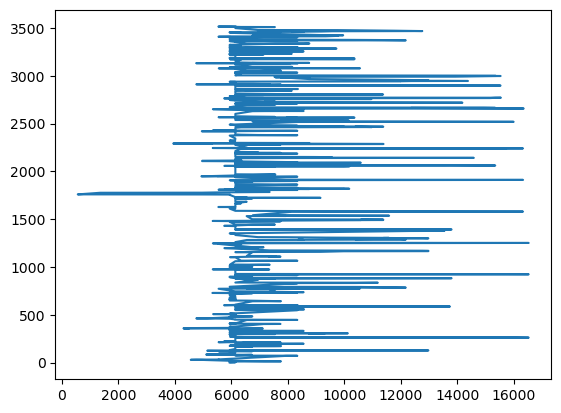

In [19]:
x = grouped_data[1]['combined_xy']
y = grouped_data[1]['combined_t']

plt.plot(x, y)

In [143]:
class TrajectoryDataset(Dataset):
    def __init__(self, grouped_data, window_size):
        self.data = grouped_data
        self.window_size = window_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_for_uid = self.data[idx]
        inputs, labels, positions, label_positions = generate_sequences(
                                                         data_for_uid['combined_xy'].values.tolist(),
                                                         data_for_uid['combined_t'].values.tolist(),
                                                         self.window_size)
        # TODO: Only first 500 trajectories for all users are extracted for now
        # To fix this I think the whole dataset needs to be restructured
        # ,regardless of the uid, i.e. just pay attention to the movement of any arbitrary user
        # like the first 500 movement of an arbitray user would be in the same mid (movement id)
        # but what is the point of using positional embedding if this is the case
        # because basically, you are focus only on the movement of the user
        # so...should LSTM work better in terms of its speed and simplicity
        # and having a similar purpose as the Transformer?
        return torch.tensor(inputs[0]), torch.tensor(labels[0]), \
                torch.tensor(positions[0]), torch.tensor(label_positions[0])

test_dataset = TrajectoryDataset(grouped_data, WINDOW_SIZE)

In [144]:
# Example
test_dataset.__getitem__(0) # uid=23, inputs, labels, positions, label_positions

(tensor([36446, 37454, 37454, 37249, 36246, 36246, 36246, 36649, 36246, 36848,
         36246, 36246, 36446, 36246, 36246, 36247, 36246, 37048, 37453, 36649,
         36049, 35849, 35648, 35450, 35650, 36246, 36446, 36246, 36246, 37454,
         37452, 36246, 36246, 36246, 36449, 35454, 36251, 36246, 36249, 36446,
         36246, 36246, 36246, 36246, 36247, 36246, 37457, 36246, 36246, 36247,
         36648, 37454, 37249, 36251, 36051, 36251, 36248, 36246, 36247, 36246,
         37251, 36446, 36247, 36247, 36447, 36246, 37454, 36246, 33456, 36246,
         36246, 36246, 36246, 36246, 36246, 35448, 33652, 36852, 37455, 36848,
         36246, 36246, 36247, 36247, 36440, 36639, 36246, 36246, 37849, 39854,
         36246, 36246, 36247, 36246, 36246, 37452, 37454, 36246, 36246, 36246,
         36246, 36246, 36246, 36246, 36247, 36246, 36247, 36246, 36246, 36246,
         36648, 36848, 37454, 36246, 36246, 36246, 36247, 36448, 36247, 36246,
         36246, 36246, 36247, 36246, 36246, 36247, 3

In [155]:
def collate_fn(batch):
    """
    batch: Dataset
    """
    # Unzip all batch
    inputs_batch, labels_batch, positions_batch, label_positions_batch = zip(*batch)
    
    # Pad the sequence with less length in a batch
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs_batch, padding_value=0.0)
    # labels_padded = torch.nn.utils.rnn.pad_sequence(labels_batch, padding_value=0.0)
    labels_padded = torch.tensor(np.array(labels_batch))
    positions_padded = torch.nn.utils.rnn.pad_sequence(positions_batch, padding_value=0)
    label_positions_padded = torch.tensor(np.array(label_positions_batch))
    
    return inputs_padded, labels_padded, positions_padded, label_positions_padded

In [156]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [157]:
# Example

data_iter = iter(test_dataloader)
inputs, labels, positions, label_positions = next(data_iter)

print("Shape of inputs:", inputs.shape) # [sqe_len, batch_size]
print("Shape of labels:", labels.shape)
print("Shape of positions:", positions.shape)
print("Shape of positions:", label_positions.shape)

Shape of inputs: torch.Size([500, 50])
Shape of labels: torch.Size([50])
Shape of positions: torch.Size([500, 50])
Shape of positions: torch.Size([50])


## Input Embedding and Positional Encoding

https://pytorch.org/tutorials/beginner/transformer_tutorial.html#load-and-batch-data

In [66]:
EMBED_DIM = 64

In [89]:
# Space - Input Embedding

# 40000 = 200 * 200

class InputEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(InputEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        """
        x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        return self.embedding(x)

In [90]:
# Time - Positional Encoding = Time Embedding + Sequential Encoding

# max_len is the maximum expected data length

class PositionalEncoding(nn.Module):
    def __init__(self, max_len, embedding_dim, dropout):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout) # prevent overfitting
        self.embedding_dim = embedding_dim

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 0, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [158]:
# Example

input_embedding_layer = InputEmbedding(40000, EMBED_DIM) # max_len, embedding_dim
position_embedding_layer = nn.Embedding(3600, EMBED_DIM) # max_len, embedding_dim
positional_encoding = PositionalEncoding(3600, EMBED_DIM, 0.1) # max_len, embedding_dim, dropout

space_time = torch.tensor([])

for inputs, labels, positions, label_positions in test_dataloader:
    # Input Embedding
    space = input_embedding_layer(inputs)
    
    # Positional Encoding
    positions = position_embedding_layer(positions)
    time = positional_encoding(positions)
    
    # Display shapes
    print("Input Embedding:", space.shape) # [seq_size, batch_size, embed_dim]
    print("Positional Encoding:", time.shape)
    
    # Concatenation
    # space_time = torch.cat((space, time), dim=2)
    
    # Addition
    space_time = space + time

    break

Input Embedding: torch.Size([500, 50, 64])
Positional Encoding: torch.Size([500, 50, 64])


## Self-Attention

In [129]:
NUM_HEADS = 8

In [130]:
class MultiHeadAttentionModule(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttentionModule, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, query, key, value, key_padding_mask=None, need_weights=True):
        attn_output, attn_output_weights = self.multihead_attn(query, key, value, attn_mask=key_padding_mask)
        return attn_output, attn_output_weights

In [131]:
# Example

multihead_attention = MultiHeadAttentionModule(EMBED_DIM, NUM_HEADS) # EMBED_DIM*2 if using concatenation
attn_output, attn_weights = multihead_attention(space_time, space_time, space_time)

print("Self Attention:", attn_output.shape) # [seq_size, batch_size, (space embed_dim + time embed_dim)]
print(attn_output)

Self Attention: torch.Size([500, 50, 64])
tensor([[[-0.1103, -0.2069,  0.1531,  ..., -0.0426,  0.0318, -0.1362],
         [-0.2952, -0.2202,  0.7420,  ..., -0.1268,  0.1803, -0.1732],
         [ 0.0980, -0.3474,  0.2576,  ...,  0.1212,  0.1180, -0.1179],
         ...,
         [-0.0422, -0.2879,  0.4252,  ...,  0.0434,  0.3268, -0.0590],
         [-0.2901, -0.1478,  0.1555,  ...,  0.1551, -0.0478,  0.0103],
         [ 0.1312, -0.1490,  0.1305,  ...,  0.2758,  0.2974, -0.1895]],

        [[-0.1274, -0.2267,  0.2636,  ...,  0.1456, -0.1611, -0.0985],
         [-0.1904, -0.1369,  0.2503,  ..., -0.0821,  0.0794,  0.0371],
         [ 0.2912, -0.3146,  0.0513,  ...,  0.1500,  0.2346,  0.1337],
         ...,
         [-0.3879, -0.1773,  0.0855,  ...,  0.0501,  0.0173,  0.1373],
         [-0.3205, -0.1173,  0.3983,  ...,  0.2287,  0.1844, -0.0054],
         [ 0.1665,  0.0259,  0.1635,  ...,  0.1820,  0.2353, -0.0859]],

        [[-0.0828, -0.2452,  0.3119,  ..., -0.0498, -0.0105, -0.0601],
   

## Transformer Block

In [114]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        
        # Attention Layer
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads)
        
        # Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Feed-Forward
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim), 
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim)
        )
        
        # Normalization
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value):
        attn_output, attn_weights = self.attention(query, key, value)
        x = self.dropout(self.norm1(attn_output + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        
        return out

# Encoder

In [115]:
class Encoder(nn.Module):
    def __init__(self, 
                 loc_size, 
                 time_size, 
                 embed_dim, 
                 num_layers, 
                 num_heads, 
                 device, 
                 forward_expansion, 
                 dropout):
        
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = InputEmbedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim, dropout).to(device)
        
        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_dim,
                num_heads,
                dropout=dropout,
                forward_expansion=forward_expansion
            ) for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs, positions):
        # Input Embedding
        space = self.input_embedding(inputs) # Shape [seq_len, batch_size, embed_dim]

        # Positional Encoding
        positions = self.position_embedding(positions) 
        time = self.positional_encoding(positions) # Shape [seq_len, batch_size, embed_dim]

        # Concatenation
        # out = torch.cat((space, time), dim=2)
        
        # Addition
        out = space + time

        # Transformer Block = Multi-Head Attention + Norm + Feed Forward + Norm
        for layer in self.layers:
            out = layer(out, out, out)

        return out

# Decoder (Debugging)

**Input** to the Decoder:

**During Training**: The decoder receives the correct labels as input. This is usually shifted right (i.e., the input begins with a start token and all elements are the target sequence excluding the last token), encouraging the model to predict the next token in the sequence.

**During Inference**: The decoder starts with a start token and generates each subsequent token based on the previously generated tokens.

The decoder uses the outputs from the encoder to help guide the generation of the output sequence.

The decoder should output logits for each token in the sequence, which can be converted into probabilities using softmax for each possible token in the label space.

In [163]:
input_embedding_layer = InputEmbedding(40000, EMBED_DIM) # max_len, embedding_dim
position_embedding_layer = nn.Embedding(3600, EMBED_DIM) # max_len, embedding_dim
positional_encoding = PositionalEncoding(3600, EMBED_DIM, 0.1) # max_len, embedding_dim, dropout

space_time = torch.tensor([])

for inputs, labels, positions, label_positions in test_dataloader:
    # Input Embedding
    space = input_embedding_layer(labels)
    
    # Positional Encoding
    positions = position_embedding_layer(label_positions)
    time = positional_encoding(positions)
    
    # Display shapes
    print("Input Embedding:", space.shape) # [seq_size, batch_size, embed_dim]
    print("Positional Encoding:", time.shape)
    
    # Concatenation
    # space_time = torch.cat((space, time), dim=2)
    
    # Addition
    space_time = space + time
    print("Added Shape:", space_time.shape)

    break

Input Embedding: torch.Size([50, 64])
Positional Encoding: torch.Size([50, 50, 64])
Added Shape: torch.Size([50, 50, 64])


In [127]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, forward_expansion, device):
        super(DecoderBlock, self).__init__()
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, value, key):
        attention = self.attention(x,x,x)
        query = self.dropout(self.norm(attention+x))
        out = self.transformer_block(query, key, value)
        
        return out

In [133]:
class Decoder(nn.Module):
    def __init__(self, 
                 loc_size, 
                 time_size, 
                 embed_dim, 
                 num_layers, 
                 num_heads, 
                 device, 
                 forward_expansion, 
                 dropout):
        
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = InputEmbedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim, dropout).to(device)
        
        self.layers = nn.ModuleList([
            DecoderBlock(
                embed_dim,
                num_heads,
                dropout=dropout,
                forward_expansion=forward_expansion,
                device=device
            ) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(embed_dim, loc_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, output, output_position, enc_out):
        space = self.input_embedding(output)
        positions = self.position_embedding(output_position)
        time = self.positional_encoding(positions)
        
        # Concatenation
        # out = torch.cat((space, time), dim=2)
        
        # Addition
        out = space + time

        for layer in self.layers:
            out = layer(enc_out, enc_out, out) # query, key, value

        out = self.fc_out(x)
        
        return out

# Training

In [121]:
# Model parameters

BATCH_SIZE = 50
EMBED_DIM = 64
NUM_HEADS = 8
NUM_LAYERS = 8
LOC_SIZE = 200*200
TIME_SIZE = 3600
FORWARD_EXPANSION = 4
DROPOUT = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = Encoder(loc_size=LOC_SIZE, 
                time_size=TIME_SIZE, 
                embed_dim=EMBED_DIM, 
                num_layers=NUM_LAYERS, 
                num_heads=NUM_HEADS, 
                device=device, 
                forward_expansion=FORWARD_EXPANSION, 
                dropout=DROPOUT)

model = model.to(device)

# Loss function
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Haven't had a Decoder yet

In [124]:
def train(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels, positions in dataloader:
            inputs, labels, positions = inputs.to(device), labels.to(device), positions.to(device)

            # Forward pass
            outputs = model(inputs, positions)  # Shape [seq_len, batch_size, loc_size]
            outputs = outputs.view(-1, LOC_SIZE)  # Reshape for loss calculation
            labels = labels.view(-1)  # Adjust labels shape to fit loss function requirements

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()f
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

train(model, test_dataloader, criterion, optimizer, num_epochs=3)